In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.stats as stats
import statsmodels.api as sm

from pandas.plotting import scatter_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from sklearn.datasets import make_classification
from sklearn.metrics import precision_recall_curve, roc_curve, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, auc
from sklearn.preprocessing import Normalizer
from sklearn import metrics

import sys
sys.path.insert(0, '../src')
sys.path.insert(0, '../data')

import functions
import plot
import clean
import models

from sklearn.preprocessing import Normalizer

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Setup variables

In [28]:
seed = 8
columns = ['DEP', 'PT', 'AGE', 'GT', 'EL', 'SC', 'CO', 'FA', 'ST']

poas_filepath = '../data/poas'
poas_filenames = ['poas16.xlsx', 'poas17.xlsx', 'poas18.xlsx', 'poas19.xlsx', 'poas20.xlsx', 'poas21.xlsx', 'poas22.xlsx']

sfas_filepath = '../data/sfas'
sfas_filenames = ['sfas16.xlsx', 'sfas17.xlsx', 'sfas18.xlsx', 'sfas19.xlsx', 'sfas20.xlsx', 'sfas21.xlsx', 'sfas22.xlsx']

## Data Import & Cleaning

Psychological Operations Assessment and Selection (POAS)

In [29]:
poas = clean.clean_data(poas_filepath, poas_filenames, columns, 'POAS')
poas.to_excel('../data/poas/poas.xlsx', index=False)

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


Special Forces Assesment and Selection (SFAS)

In [30]:
sfas = clean.clean_data(sfas_filepath, sfas_filenames, columns, 'SFAS')
poas.to_excel('../data/sfas/sfas.xlsx', index=False)

/opt/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Conditional Formatting extension is not supported and will be removed
  for idx, row in parser.parse():


## Initial Overview

View of overall data

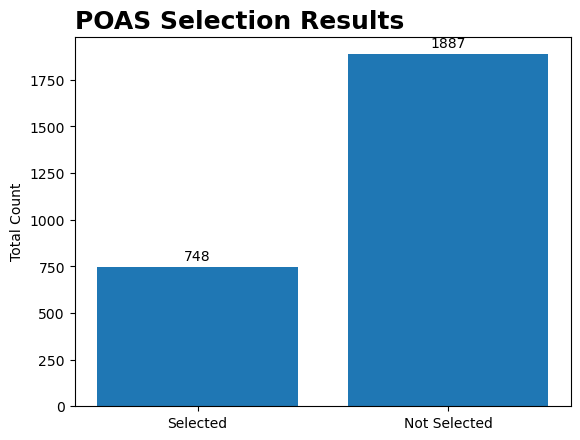

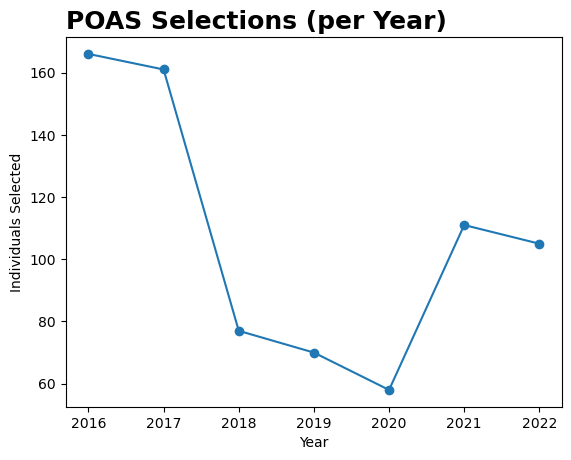

In [31]:
poas_selected = functions.equal_column_val(poas, 'RESULT', 'SELECTED')
poas_not_selected = functions.not_column_val(poas, 'RESULT', 'SELECTED')

outcome = [poas_selected.RESULT.count(), poas_not_selected.RESULT.count()]

plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'POAS Selection Results', 'Total Count')
plot.annual_line_plot(poas_selected, 'POAS Selections (per Year)', 'Year', 'Individuals Selected')

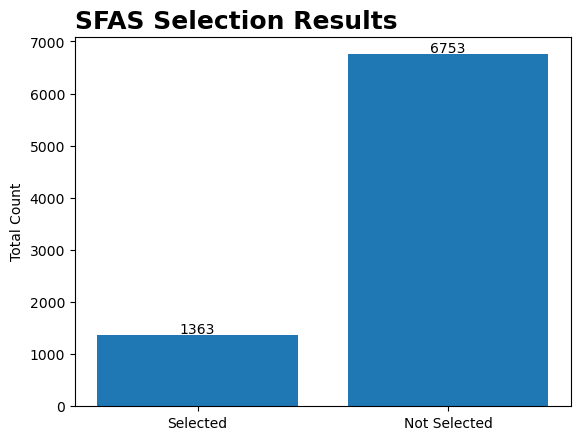

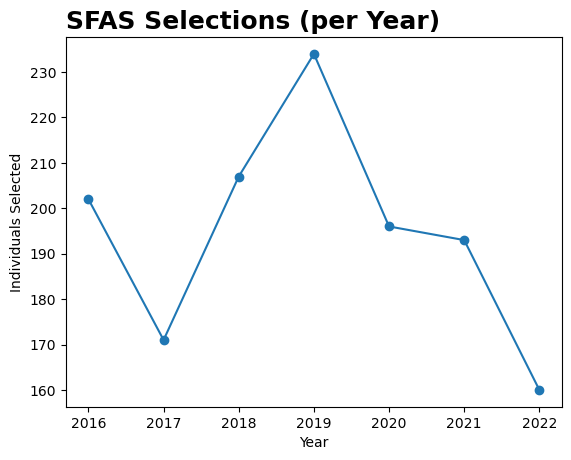

In [32]:
sfas_selected = functions.equal_column_val(sfas, 'RESULT', 'SELECTED')
sfas_not_selected = functions.not_column_val(sfas, 'RESULT', 'SELECTED')

outcome = [sfas_selected.RESULT.count(), sfas_not_selected.RESULT.count()]

plot.select_bar_plot(outcome, ['Selected', 'Not Selected'] , 'SFAS Selection Results', 'Total Count')
plot.annual_line_plot(sfas_selected, 'SFAS Selections (per Year)', 'Year', 'Individuals Selected')

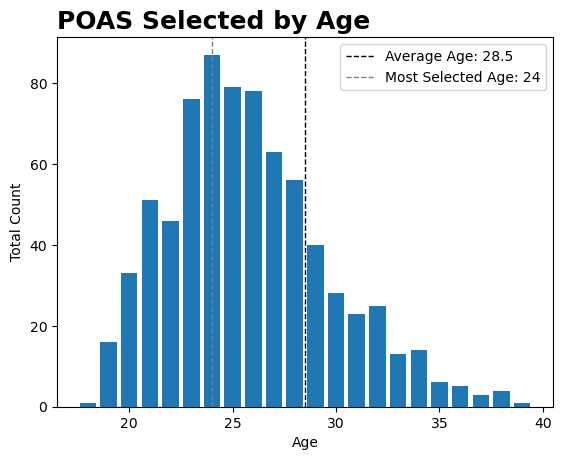

In [22]:
poas_ages = poas_selected.groupby('AGE').size().reset_index(name='counts')
poas_avg_age = poas_ages.mean()
poas_most_age = poas_ages.loc[poas_ages['counts'].idxmax(), 'AGE']

plot.age_bar_plot(poas_ages['AGE'], poas_ages['counts'], 'POAS Selected by Age', 'Age', 'Total Count', poas_avg_age[0], poas_most_age)

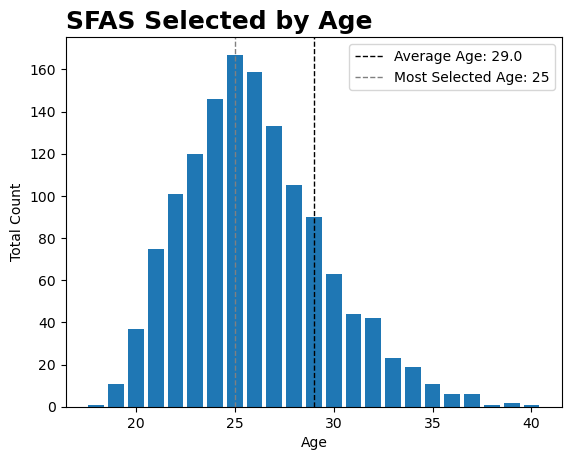

In [23]:
sfas_ages = sfas_selected.groupby('AGE').size().reset_index(name='counts')
sfas_avg_age = sfas_ages.mean()
sfas_most_age = sfas_ages.loc[sfas_ages['counts'].idxmax(), 'AGE']

plot.age_bar_plot(sfas_ages['AGE'], sfas_ages['counts'], 'SFAS Selected by Age', 'Age', 'Total Count', sfas_avg_age[0], sfas_most_age)

## Key Features

Numerical look at features that are often considered "important"

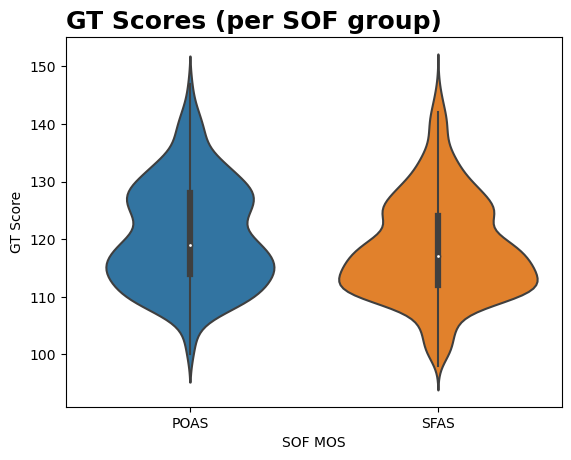

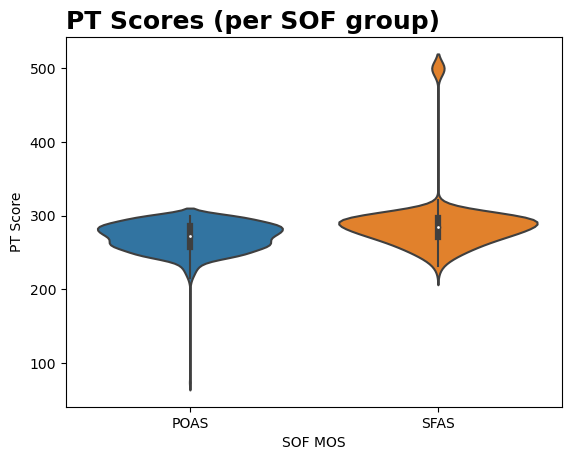

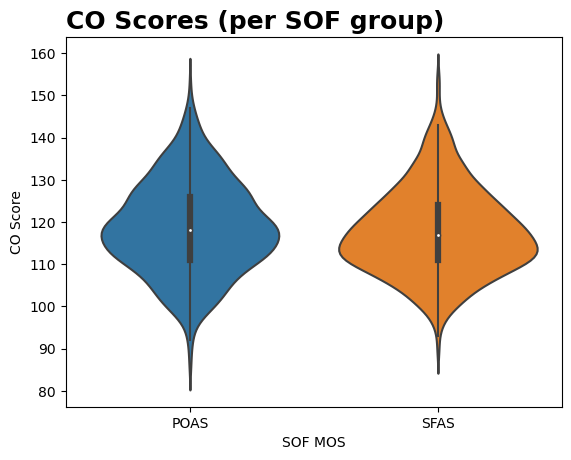

In [33]:
both = [poas, sfas]
combined = functions.combined(both)
combined_selected = functions.equal_column_val(combined, 'RESULT', 'SELECTED')

plot.violin_plot('GROUP', 'GT', combined_selected, 'GT Scores (per SOF group)', 'SOF MOS', 'GT Score')
plot.violin_plot('GROUP', 'PT', combined_selected, 'PT Scores (per SOF group)', 'SOF MOS', 'PT Score')
plot.violin_plot('GROUP', 'CO', combined_selected, 'CO Scores (per SOF group)', 'SOF MOS', 'CO Score')

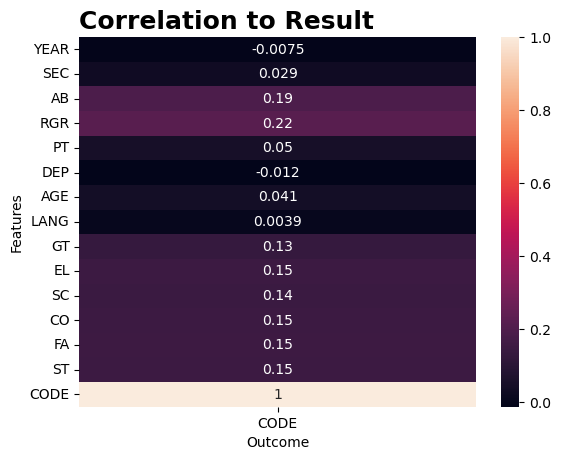

In [35]:
plot.select_correlation(combined, 'Correlation to Result', 'Outcome', 'Features')

## POAS Pre-Model

In [36]:
rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6}
poas.RANK = poas.RANK.replace(rank_vals)
poas2 = poas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)

In [44]:
poasX = poas2.drop('CODE', axis=1)
poasX2 = Normalizer().fit_transform(poasX)
poasy = poas2.CODE

## POAS Info

In [51]:
poas_split = functions.train_split(poasX2, poasy)

In [52]:
poas_info = sm.OLS(poas_split[2], poas_split[0]).fit()
print(poas_info.summary())

                                 OLS Regression Results                                
Dep. Variable:                   CODE   R-squared (uncentered):                   0.324
Model:                            OLS   Adj. R-squared (uncentered):              0.319
Method:                 Least Squares   F-statistic:                              66.93
Date:                Thu, 02 Feb 2023   Prob (F-statistic):                   1.30e-165
Time:                        12:00:56   Log-Likelihood:                         -1250.2
No. Observations:                2108   AIC:                                      2530.
Df Residuals:                    2093   BIC:                                      2615.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## POAS Logistic Regression Model

Single Logistic Regression Model

Test accuracy: 53.32%
Test precision: 0.31
Test recall: 0.51


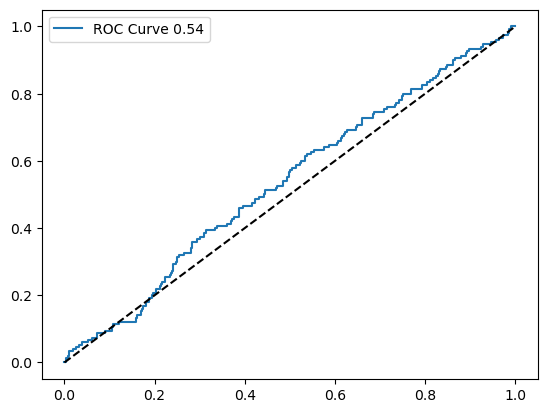

In [53]:
poas_single_model = models.regression_model(poas_split[0], poas_split[1], poas_split[2], poas_split[3])

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 60.34%
Mean Precision: 0.38
Mean Recall: 0.60


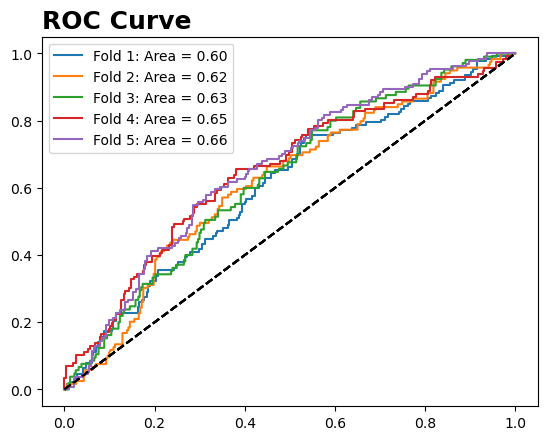

In [54]:
poas_multi = models.multiple_regression_model(poasX, poasy, 5)

## SFAS Pre-Model


In [55]:
rank_vals = {'PV2': 2, 'PFC': 3, 'CPL': 4, 'SPC': 4, 'SGT': 5, 'SSG': 6, 'SFC': 7, 'SSGT': 6, 'SRA': 4, 'SN': 3, 'AF': 4}
sfas.RANK = sfas.RANK.replace(rank_vals)
sfas2 = sfas.drop(['YEAR', 'RACE', 'MOS', 'ED', 'MARITAL', 'RESULT', 'GROUP'], axis=1)

In [56]:
sfasX = sfas2.drop('CODE', axis=1)
sfasX2 = Normalizer().fit_transform(sfasX)
sfasy = sfas2.CODE

## SFAS Info

In [57]:
sfas_split = functions.train_split(sfasX2, sfasy)
sfas_info = sm.OLS(sfas_split[2], sfas_split[0]).fit()
print(sfas_info.summary())

                                 OLS Regression Results                                
Dep. Variable:                   CODE   R-squared (uncentered):                   0.255
Model:                            OLS   Adj. R-squared (uncentered):              0.253
Method:                 Least Squares   F-statistic:                              147.7
Date:                Thu, 02 Feb 2023   Prob (F-statistic):                        0.00
Time:                        12:08:50   Log-Likelihood:                         -2464.9
No. Observations:                6492   AIC:                                      4960.
Df Residuals:                    6477   BIC:                                      5061.
Df Model:                          15                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

## SFAS Logistic Regression Model

Single Logistic Regression Model

Test accuracy: 53.45%
Test precision: 0.20
Test recall: 0.57


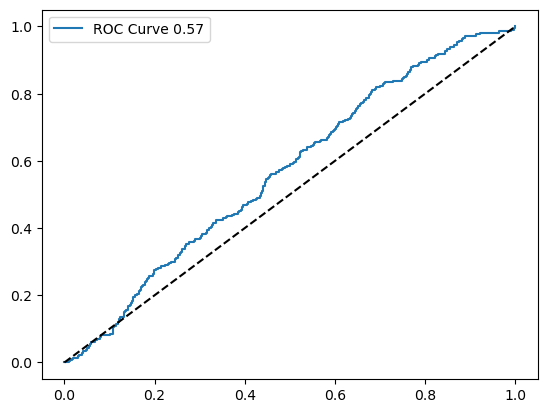

In [58]:
sfas_single_model = models.regression_model(sfas_split[0], sfas_split[1], sfas_split[2], sfas_split[3])

Multiple Models using KFolds

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

Mean Accuracy: 68.96%
Mean Precision: 0.29
Mean Recall: 0.57


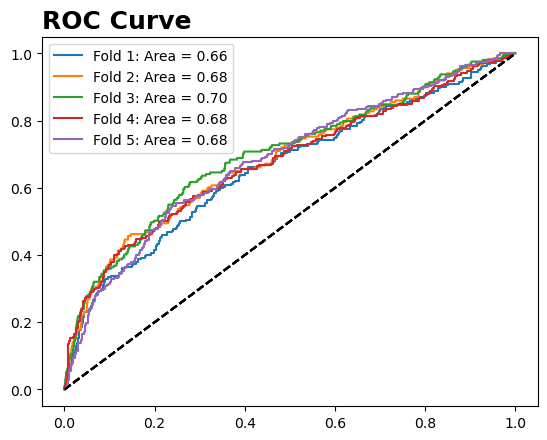

In [59]:
sfas_multi = models.multiple_regression_model(sfasX, sfasy, 5)